<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_Clustering_DBSCAN_Emma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTILS

### Load Libraries

In [407]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import os
import random
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.manifold import TSNE

### Utils for Data Preparation

In [408]:
META_COL = ['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'clusters', 'new_clusters']
SHAP_COL = ['Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male',
            'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic',
            'Shap_race_Native American', 'Shap_race_Other']
BASIC_COL = ['age', 'priors_count', 'sex_Female', 'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian',
             'race_Hispanic', 'race_Native American', 'race_Other', 'error_scaled' ]
META_COL_VIZ = ['predicted_class', 'true_class', 'TP', 'TN', 'FN', 'FP', 'error_scaled', 'Error_Type', 'new_clusters']
ONE_HOT_RACE = ['race_African-American', 'race_Asian', 'race_Caucasian',
             'race_Hispanic', 'race_Native American', 'race_Other']
SHORT_LABEL_RACE = ['Afr.Am.', 'Asian', 'Cauc.', 'Hisp.', 'Native', 'Other']
ONE_HOT_GENDER = ['sex_Female', 'sex_Male']
SHORT_LABEL_GENDER = ['Female', 'Male']

In [409]:
# Scale features, but not "meta column"
def scale_data(data_fixed, meta_col = np.concatenate((META_COL, ONE_HOT_RACE, ONE_HOT_GENDER)),
               redo_one_hot=True):
  data = data_fixed.copy(deep=True)
  features = data.drop(meta_col, axis=1)
  to_scale = features.columns
  #data[to_scale] = StandardScaler().fit_transform(features[to_scale])
  data[to_scale] = MinMaxScaler().fit_transform(features[to_scale])
  for col in meta_col:
          data[col] = data_fixed[col]
  return data

# Keep only rows with the type of errors to target (e.g., TP & FN, or TN & FP, ...)
def filter_error_rows(data, error_col='FN', correct_col='TP'):
  return data.loc[(data[error_col] == 1) | (data[correct_col] == 1)]

# Drop "meta columns" not containing data features or SHAP features
def drop_column(data, to_drop = META_COL):
  for c in to_drop:
    if c in data.columns:
      data = data.drop(c, axis=1)
  return data

# Initialise clustering dataset, with added columns for cluster IDs, and a deep copy for future changes of the cluster IDs
def init_cluster_col(data):
    data['clusters'] = 0
    data['new_clusters'] = -1
    return data

# Initialise clustering dataset, with added columns for cluster IDs, and a deep copy for future changes of the cluster IDs
def init_error_as_a_feature(data):
    data['error_scaled'] = data['errors']
    return data

def basic_data_prep(data_fixed, error_col='', correct_col='', shap=False, redo_one_hot = False):
  data = data_fixed.copy(deep=True)
  data = init_error_as_a_feature(data)
  data = init_cluster_col(data)
  if not shap:
    data = drop_column(data, SHAP_COL)
  if error_col != '' and correct_col != '':
    data = filter_error_rows(data, error_col, correct_col)
  if redo_one_hot:
    data = redo_one_hot_values(data, ONE_HOT_RACE)
    data = redo_one_hot_values(data, ONE_HOT_GENDER)
  return scale_data(data)

In [410]:
def undo_one_hot(data, one_hot_col=ONE_HOT_RACE, col_label='race',
                 numeric_values=True, short_label=SHORT_LABEL_RACE):
  data[col_label] = ''
  i=0
  for c in one_hot_col:
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
        data.loc[data[c] == values[1], col_label] = short_label[i]
    i += 1
    data = data.drop(c, axis=1)
  return(data)

# The function pd.from_dummies() bugs: it does not assign the right race, or does not keep their order
def undo_one_hot_BUG(data, one_hot_col=ONE_HOT_RACE, col_label='race', numeric_values=True):
  data_encoded = data
  print(data.head())
  for c in data_encoded.columns:
    if not c in one_hot_col:
      data_encoded = data_encoded.drop(c, axis=1)
    else:
      values = np.sort(data_encoded[c].unique())
      data_encoded.loc[data_encoded[c] == values[0], c] = 0
      data_encoded.loc[data_encoded[c] == values[1], c] = 1
  print(data_encoded.head())
  data[col_label] = pd.from_dummies(data_encoded)
  print(data.head())

  i=1
  for c in np.sort(one_hot_col):
    data = data.drop(c, axis=1)
    if numeric_values:
      data.loc[data[col_label] == c, col_label] = i
      i += 1
  return(data)

def redo_one_hot_values(data, one_hot_col=ONE_HOT_RACE):
  for c in data.columns:
    if c in one_hot_col:
      values = np.sort(data[c].unique())
      data.loc[data[c] == values[0], c] = 0
      data.loc[data[c] == values[1], c] = 1
  return(data)

### Utils for Error Rate Calculation

In [411]:
# Calculate error rate, replacing accuracy_error()
def get_error_rate(data):
  if len(data) == 0:
    print ("you are calculating the error rate of an empty cluster")
    return
  return data.loc[:, 'errors'].mean()

# Calculate bias in terms of error difference
# bias_type can be:
#   - 'negative' i.e., negative discrimination, when the target_cluster has more error than other cluster
#   - 'positive' i.e., positive discrimination, when the target_cluster has less error than other cluster
#   - 'absolute' the target_cluster can have either more or less error than other cluster
# baseline can be:
#   - 'other' i.e., clusters other than the target_cluster
#   - 'all' i.e., all clusters including the target_cluster
#   - 'best' i.e., the cluster with the smallest error rate
def get_error_diff(data, cluster_id, cluster_col, bias_type='negative', baseline='other', full_info=False):
  cluster_x = data.loc[data[cluster_col] == cluster_id]
  if len(cluster_x) == 0:
    print("this is an empty cluster", cluster_id)
    return

  if baseline == 'other':
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
      print ("This cluster is the entire dataset. Cluster:", cluster_id)
      return
    error_diff = get_error_rate(cluster_x) - get_error_rate(remaining_clusters)

  if baseline == 'all':
    error_diff = get_error_rate(cluster_x) - get_error_rate(data)

  if baseline == 'best':
    best_cluster = get_cluster_w_min_bias(data, cluster_col, bias_type, baseline)
    error_diff = get_error_rate(cluster_x) - best_cluster[1]

  if full_info:
    return [error_diff, get_error_rate(cluster_x), get_error_rate(remaining_clusters)]

  if bias_type == 'positive':
    error_diff = -error_diff
  if bias_type == 'absolute':
    error_diff = np.absolute(error_diff)
  return error_diff

### Utils for Visualization

In [447]:
# PCA Plot clusters
def pca_plot(data, title, alpha=0.3, s=2, palette='tab10',
             style='Error_Type', hue='clusters', verbose = False):
  # Extract features for PCA and drop certain columns
  pca_features = drop_column(data, META_COL)

  if 'error_scaled' in pca_features.columns:
    # print('Scaled error: ', pca_features['error_scaled'].unique())
    pca_features = pca_features.drop('error_scaled', axis=1)

  if hue == 'clusters':
    palette = sns.color_palette("cubehelix_r", len(data['clusters'].unique()))

  # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
  pca = PCA(n_components=2)
  pca_result = pca.fit_transform(pca_features)
  pca_df = pd.DataFrame(pca_result, index=pca_features.index, columns=['Principal Component 1', 'Principal Component 2'])

  # Create temporary dataset that contains both principal components and other features
  temp_data = pca_df.join(data[META_COL], how='left')

  # Create scatterplot using seaborn
  sns.set(rc = {'figure.figsize':(5, 5)})
  sns.set_style("ticks")
  scatterplot = sns.scatterplot(data=temp_data, x='Principal Component 1', y='Principal Component 2',
                                alpha=alpha, hue=hue, palette=palette, style=style, s=s)
  #scatterplot.set_title(title)
  scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

  if verbose:
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

  plt.show()

In [413]:
def prepare_to_viz(data_fixed, to_drop=META_COL_VIZ):
  data = data_fixed.copy(deep=True)
  data = drop_column(data, to_drop=to_drop)
  data['cluster_id'] = data['clusters'].astype(str)
  data = undo_one_hot(data, one_hot_col=ONE_HOT_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
  data = undo_one_hot(data, one_hot_col=ONE_HOT_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)
  return data

def merge_results(d1, d2, d3, d4, viz_labels):
  l1 = viz_labels[0]
  l2 = viz_labels[1]
  l3 = viz_labels[2]
  l4 = viz_labels[3]

  data = d1.copy(deep=True)
  data = undo_one_hot(data, one_hot_col=ONE_HOT_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
  data = undo_one_hot(data, one_hot_col=ONE_HOT_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)
  data = drop_column(data, to_drop=META_COL_VIZ)
  data = drop_column(data, to_drop=['clusters', 'cluster_id', 'new_clusters'])

  data[l1] = d1['clusters']#.astype(str)
  data[l2] = d2['clusters']#.astype(str)
  data[l3] = d3['clusters']#.astype(str)
  data[l4] = d4['clusters']#.astype(str)

  return data

def get_max_ncluster(data, viz_labels):
  n = 1
  cid = 0
  for l in viz_labels:
    if len(data[l].unique()) > n:
      n = len(data[l].unique())
      cid = l
  return [cid, n]

In [463]:
def get_error_percentage(data, group_by='cluster_id'):
  data = drop_column(data, to_drop=META_COL_VIZ)
  data['error_percentage'] = data['errors']
  for g in data[group_by].unique():
    data.loc[data[group_by] == g, 'error_percentage'] *= 100 / len(data.loc[data[group_by] == g])
  return data.sort_values(by=group_by)

def get_viz_error_dist_all_results(data, viz_labels):
  l1 = viz_labels[0]
  l2 = viz_labels[1]
  l3 = viz_labels[2]
  l4 = viz_labels[3]

  overall_error_rate = 100 * get_error_rate(data)

  sns.set_style("ticks")
  f, axs = plt.subplots(2, 6, figsize=(24, 8)) #, gridspec_kw=dict(width_ratios=[4, 3]))
  sns.histplot(data.sort_values(by='gender'), x='gender', hue="errors", multiple="stack", ax=axs[0,0])
  sns.histplot(data.sort_values(by='race'), x='race', hue="errors", multiple="stack", ax=axs[0,1])
  sns.histplot(data.sort_values(by=l1), x=l1, hue="errors", multiple="stack", ax=axs[0,2])
  sns.histplot(data.sort_values(by=l2), x=l2, hue="errors", multiple="stack", ax=axs[0,3])
  sns.histplot(data.sort_values(by=l3), x=l3, hue="errors", multiple="stack", ax=axs[0,4])
  sns.histplot(data.sort_values(by=l4), x=l4, hue="errors", multiple="stack", ax=axs[0,5])

  sns.barplot(get_error_percentage(data, 'gender'), x='gender', y='error_percentage', estimator=sum, hue="errors", errorbar=None, ax=axs[1,0]).legend_.remove()
  sns.barplot(get_error_percentage(data, 'race'), x='race', y='error_percentage', estimator=sum, hue="errors", errorbar=None, ax=axs[1,1]).legend_.remove()
  sns.barplot(get_error_percentage(data, l1), x=l1, y='error_percentage', estimator=sum, hue="errors", errorbar=None, ax=axs[1,2]).legend_.remove()
  sns.barplot(get_error_percentage(data, l2), x=l2, y='error_percentage', estimator=sum, hue="errors", errorbar=None, ax=axs[1,3]).legend_.remove()
  sns.barplot(get_error_percentage(data, l3), x=l3, y='error_percentage', estimator=sum, hue="errors", errorbar=None, ax=axs[1,4]).legend_.remove()
  sns.barplot(get_error_percentage(data, l4), x=l4, y='error_percentage', estimator=sum, hue="errors", errorbar=None, ax=axs[1,5]).legend_.remove()

  axs[1,0].set_ylim(0, 100)
  axs[1,1].set_ylim(0, 100)
  axs[1,2].set_ylim(0, 100)
  axs[1,3].set_ylim(0, 100)
  axs[1,4].set_ylim(0, 100)
  axs[1,5].set_ylim(0, 100)

  axs[1,0].axhline(overall_error_rate, ls='--')
  axs[1,1].axhline(overall_error_rate, ls='--')
  axs[1,2].axhline(overall_error_rate, ls='--')
  axs[1,3].axhline(overall_error_rate, ls='--')
  axs[1,4].axhline(overall_error_rate, ls='--')
  axs[1,5].axhline(overall_error_rate, ls='--')

  #axs[1,:].get_legend().remove()

  f.tight_layout()
  plt.show()

In [415]:
def get_viz_matrix_all_results(data, viz_labels):
  max_ncluster = get_max_ncluster(data, viz_labels)
  sns.set_style("ticks")
  palette = sns.color_palette("cubehelix_r", max_ncluster[1])
  g = sns.PairGrid(data.sort_values(by=max_ncluster[0]), hue=max_ncluster[0],
                   palette=palette,
                   y_vars=['priors_count', 'age', 'gender', 'race'],
                   x_vars=viz_labels)
  g.map(sns.histplot, alpha=0.5)
  plt.show()

In [416]:
def get_viz_overlap_all_results(data, viz_labels):
  l1 = viz_labels[0]
  l2 = viz_labels[1]
  l3 = viz_labels[2]
  l4 = viz_labels[3]

  data[l1] = data[l1].astype(str)
  data[l2] = data[l2].astype(str)
  data[l3] = data[l3].astype(str)
  data[l4] = data[l4].astype(str)
  sns.set_style("ticks")
  f, axs = plt.subplots(3, 3, figsize=(15, 15)) #, gridspec_kw=dict(width_ratios=[4, 3]))

  d1 = get_pairwise_overlap(data, l2, l1)
  sns.heatmap(d1, annot=True, fmt=".0f", cmap=sns.light_palette("seagreen", as_cmap=True), cbar=False, mask=(d1==0), annot_kws={"fontsize":10}, ax=axs[0, 0])
  axs[0,1].axis('off')
  axs[0,2].axis('off')

  d1 = get_pairwise_overlap(data, l3, l1)
  d2 = get_pairwise_overlap(data, l4, l2)
  sns.heatmap(d1, annot=True, fmt=".0f", cmap=sns.light_palette("seagreen", as_cmap=True), cbar=False, mask=(d1==0), annot_kws={"fontsize":10}, ax=axs[1, 0])
  sns.heatmap(d2, annot=True, fmt=".0f", cmap=sns.light_palette("seagreen", as_cmap=True), cbar=False, mask=(d2==0), annot_kws={"fontsize":10}, ax=axs[1, 1])
  axs[1,2].axis('off')

  d1 = get_pairwise_overlap(data, l4, l1)
  d2 = get_pairwise_overlap(data, l4, l2)
  d3 = get_pairwise_overlap(data, l4, l3)
  sns.heatmap(d1, annot=True, fmt=".0f", cmap=sns.light_palette("seagreen", as_cmap=True), cbar=False, mask=(d1==0), annot_kws={"fontsize":10}, ax=axs[2, 0])
  sns.heatmap(d2, annot=True, fmt=".0f", cmap=sns.light_palette("seagreen", as_cmap=True), cbar=False, mask=(d2==0), annot_kws={"fontsize":10}, ax=axs[2, 1])
  sns.heatmap(d3, annot=True, fmt=".0f", cmap=sns.light_palette("seagreen", as_cmap=True), cbar=False, mask=(d3==0), annot_kws={"fontsize":10}, ax=axs[2, 2])

def get_pairwise_overlap(data, l1, l2):
  d_count = pd.DataFrame({
    l1: [],
    l2: [],
    'count': []
  })

  for c1 in np.sort(data[l1].unique()):
    for c2 in np.sort(data[l2].unique()):
      count = len(data.loc[(data[l1] == c1) & (data[l2] == c2)])
      new_line = {
        l1: c1,
        l2: c2,
        'count': count
      }
      d_count = pd.concat([d_count, pd.DataFrame([new_line])], ignore_index=True)

  return d_count.pivot(index=l1, columns=l2, values="count")

## Utils for Clustering

In [417]:
# Get the cluster with the maximum error difference
def get_cluster_w_max_bias(data, cluster_col='clusters', bias_type='negative', baseline='other'):
  max_bias = 0
  max_bias_cluster = -2
  full_info = [0,0,0]
  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: # outliers in dbscan
      continue
    current_bias = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline) #pos function to find the highest bias
    if current_bias > max_bias:
      max_bias = current_bias
      max_bias_cluster = cluster_id

  full_info = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline, full_info=True)
  # print ('Cluster ID', max_bias_cluster, 'has the largest ', bias_type,' bias, compared to ', baseline,
  #       'cluster(s):\n   ', np.round(full_info[0],4), '(',np.round(full_info[1],4), ' Vs ', np.round(full_info[2],4), ')')
  return [max_bias_cluster, full_info[0]]

# Get the cluster with the minimum error difference
def get_cluster_w_min_bias(data, cluster_col='clusters', bias_type='negative', baseline='all'):
  min_bias = 1
  min_bias_cluster = -2
  full_info = [0,0,0]
  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: # outliers in dbscan
      continue
    current_bias = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline)
    if current_bias < min_bias:
      min_bias = current_bias
      min_bias_cluster = cluster_id

  full_info = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline, full_info=True)
  #print ('Cluster ID', min_bias_cluster, 'has the smallest ', bias_type,' bias, compared to ', baseline,
  #       'cluster(s):\n   ', np.round(full_info[0],4), '(',np.round(full_info[1],4), ' Vs ', np.round(full_info[2],4), ')')
  return [min_bias_cluster, full_info[0]]

#Get the size of the smallest cluster
def get_min_cluster_size(data, cluster_col='new_clusters'):
  min_cluster_size = len(data)
  for i in data[cluster_col].unique():
    if i == -1: # Outliers in DB Scan
      continue
    size = len(data.loc[data[cluster_col] == i])
    if size < min_cluster_size:
      min_cluster_size = size
  return min_cluster_size

# Select a random cluster from a list of clusters,
# Avoiding the cluster ID -1 (outliers in dbscan)
def get_random_cluster(data, cluster_col, min_splittable_cluster_size, previous_cluster, all_cluster_ids):
  for candidate_cluster_id in all_cluster_ids:
    # Do not pick outliers in dbscan
    if candidate_cluster_id == -1 or candidate_cluster_id == previous_cluster:
      continue

    print('This is the random cluster we picked:', candidate_cluster_id)

    # Check cluster size
    candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]
    if(len(candidate_cluster) < min_splittable_cluster_size):
      print('...and it is too small:', len(candidate_cluster))
      continue
    else:
      return candidate_cluster_id

  print('All remaining clusters are too small to split')
  return -2

def exit_clustering(data, msg='', bias_type='', iter=''):
  print('Iteration ', iter, ': ', msg)
  print('Overall error rate: ', get_error_rate(data))
  for c in np.sort(data['clusters'].unique()):
    print('Cluster: ', c, '\tSize: ', len(data.loc[data['clusters'] == c]), '\tError rate: ', get_error_rate(data.loc[data['clusters'] == c]))
  pca_plot(data,'HBAC-DBSCAN on COMPAS - ' + bias_type + ' bias', hue='clusters', s=15, alpha=0.8)
  return data


#DBSCAN clustering

In [429]:
def get_dbscan_clusters(data_fixed, max_iter=10, verbose=True,
                        min_splittable_cluster_size = 30, min_acceptable_cluster_size = 10,
                        eps = 0.001, dyn_eps = False, eps_dyn_rate = 1,
                        bias_type='absolute', baseline='other', min_error_diff = 0.0001,
                        meta_col = META_COL, use_error_feature='scaled'):

    data = data_fixed.copy(deep=True)
    data = init_cluster_col(data)
    if not use_error_feature == 'scaled':
      data = data.drop('error_scaled', axis=1)

    # Loop for clustering iterations
    for i in range(1, max_iter+1):
      # The epsilon value is incrementedly decreased to identify dense areas
      if dyn_eps and i > 1:
        eps *= eps_dyn_rate

      if verbose: print('Epsilon: ', eps)

      all_cluster_ids = data['clusters'].unique()
      np.random.shuffle(all_cluster_ids)
      if verbose: print('Randomised cluster IDs:', all_cluster_ids)

      for candidate_cluster_id in all_cluster_ids:
        # Do not pick outliers in dbscan
        if candidate_cluster_id == -1:
          if i > 1 and candidate_cluster_id == all_cluster_ids[(len(all_cluster_ids)-1)]:
            if dyn_eps:
              break
            else:
              return exit_clustering(data, 'No clusters can be split further', bias_type, i)
          else:
            continue

        if verbose: print('This is the cluster we picked: ', candidate_cluster_id, ' - Size: ', len(data.loc[data['clusters'] == candidate_cluster_id]))

        # Check cluster size
        candidate_cluster = data.loc[data['clusters'] == candidate_cluster_id]
        if(len(candidate_cluster) < min_splittable_cluster_size):
          if verbose: print('...and it is too small:', len(candidate_cluster))
          if i > 1 and candidate_cluster_id == all_cluster_ids[(len(all_cluster_ids)-1)]:
            if dyn_eps:
              break
            else:
              return exit_clustering(data, 'No clusters can be split further', bias_type, i)
          else:
            continue

        data['new_clusters'] = -2
        candidate_cluster = data.loc[data['clusters'] == candidate_cluster_id]

        # Apply DBSCAN
        candidate_cluster['new_clusters'] = pd.DataFrame(
            DBSCAN(eps=eps, min_samples=min_acceptable_cluster_size).fit_predict(
                candidate_cluster.drop(meta_col, axis=1)), index=candidate_cluster.index
            )

        data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

        # Check if a new cluster is found
        # print(candidate_cluster['new_clusters'].unique())
        if (len(candidate_cluster['new_clusters'].unique()) <= 2):
          if verbose: print('No new cluster was found')
          if i > 1 and candidate_cluster_id == all_cluster_ids[(len(all_cluster_ids)-1)]:
            if dyn_eps:
              break
            else:
              return exit_clustering(data, 'No clusters can be split further', bias_type, i)
          else:
            continue

        if verbose: print('New clusters were found')
        intial_cluster_error_rate = get_error_rate(candidate_cluster)
        if verbose: print("Initial cluster's error rate: ", intial_cluster_error_rate)

        new_clusters_max_error_diff = get_cluster_w_max_bias(data, cluster_col='new_clusters', bias_type=bias_type, baseline=baseline)
        new_clusters_max_error_diff = new_clusters_max_error_diff[1]
        if verbose: print("New clusters' max error diff: ", new_clusters_max_error_diff)

        if bias_type == 'negative':
          new_clusters_max_error_diff = -new_clusters_max_error_diff
        if bias_type == 'absolute':
          new_clusters_max_error_diff = np.absolute(new_clusters_max_error_diff)

        if new_clusters_max_error_diff < min_error_diff:
          if verbose: print('The new clusters have too small a max bias')
          if i > 1 and candidate_cluster_id == all_cluster_ids[(len(all_cluster_ids)-1)]:
            if dyn_eps:
              break
            else:
              return exit_clustering(data, 'No clusters can be split further', bias_type, i)
          else:
            continue

        # Add new cluster IDs
        n_cluster = len(data['clusters'].unique()) -1 # Remove 1 for the "outlier" cluster (ID -1)
        if verbose: print('Prev. No. clusters: ', n_cluster)
        first = True
        increment_id = 0
        for c in data['new_clusters'].unique():
          if (c == -1): # add to outliers
            if verbose: print('Adding new outliers to current cluster')
            data['clusters'][data['new_clusters'] == c] = -1
          elif (c == -2):
            print('-2 ??', candidate_cluster_id)
            continue
          elif first:
            if verbose: print('Keeping a subset under the initial cluster ID')
            data['clusters'][data['new_clusters'] == c] = candidate_cluster_id
            first = False
          else:
            if verbose: print('Adding data points to a new cluster ID')
            data['clusters'][data['new_clusters'] == c] =  n_cluster + increment_id
            increment_id += 1
        if verbose: print('New No. clusters: ', len(data['clusters'].unique()))
        break

    return exit_clustering(data, 'All iterations are done', bias_type, i)


# RUN EXPERIMENT

In [418]:
data = pd.read_csv('/content/Shap_error_data.csv')
data = data.dropna()

In [446]:
data_now = basic_data_prep(data, correct_col='TN', error_col='FP', redo_one_hot = True)
get_error_rate(data_now)
max_iter = 100
min_error_diff = 0.001
min_acceptable_cluster_size = 50
eps = 1
eps_dyn_rate = 0.95
bias_type = 'absolute'

## Determining Epsilon

Using the k-distance plot to determine epsilon by identifying the knee point (where there is a significant increese

Text(0.5, 1.0, 'Optimal Value of Epsilon for COMPAS')

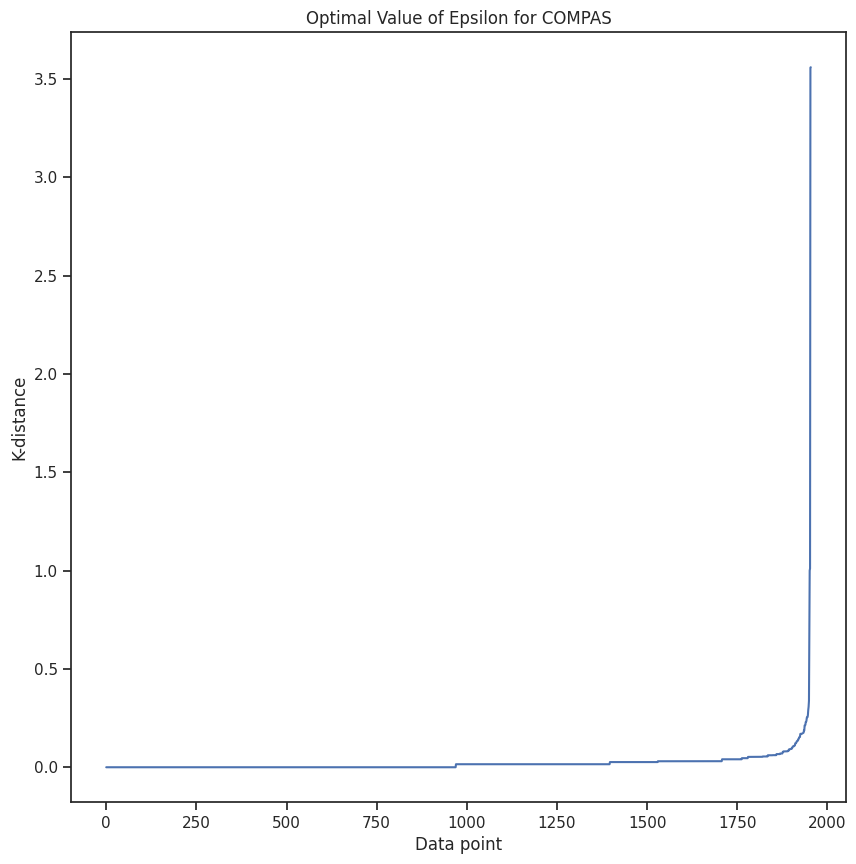

In [428]:
data_now = data_tn_fp
nn_features = data_now.iloc[:, : 11]

neigh = NearestNeighbors(n_neighbors = 3) # compute distance to 2nd nearest neighbor (k=3) for each data point
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis= 0)
distances = distances [:,1]
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('K-distance')
plt.title("Optimal Value of Epsilon for COMPAS")

## Run Clustering

Iteration  2 :  No clusters can be split further
Overall error rate:  0.33145780051150897
Cluster:  -1 	Size:  110 	Error rate:  0.6090909090909091
Cluster:  0 	Size:  1312 	Error rate:  0.33689024390243905
Cluster:  1 	Size:  123 	Error rate:  0.17886178861788618
Cluster:  2 	Size:  159 	Error rate:  0.3710691823899371
Cluster:  3 	Size:  185 	Error rate:  0.24864864864864866
Cluster:  4 	Size:  66 	Error rate:  0.18181818181818182


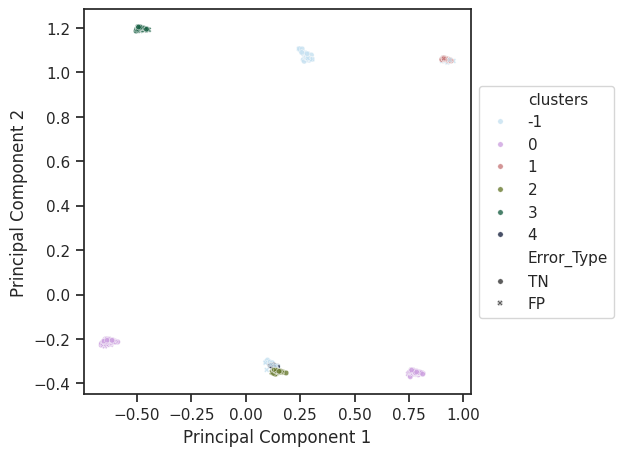

In [448]:
results_noDynEps_errorFeature = get_dbscan_clusters(data_now, bias_type=bias_type, verbose=False,
                                      eps=eps, dyn_eps=False,
                                      min_acceptable_cluster_size=min_acceptable_cluster_size,
                                      min_error_diff=min_error_diff,
                                      max_iter=max_iter)

Iteration  2 :  No clusters can be split further
Overall error rate:  0.33145780051150897
Cluster:  -1 	Size:  59 	Error rate:  0.2711864406779661
Cluster:  0 	Size:  1312 	Error rate:  0.33689024390243905
Cluster:  1 	Size:  146 	Error rate:  0.3082191780821918
Cluster:  2 	Size:  159 	Error rate:  0.3710691823899371
Cluster:  3 	Size:  185 	Error rate:  0.24864864864864866
Cluster:  4 	Size:  94 	Error rate:  0.425531914893617


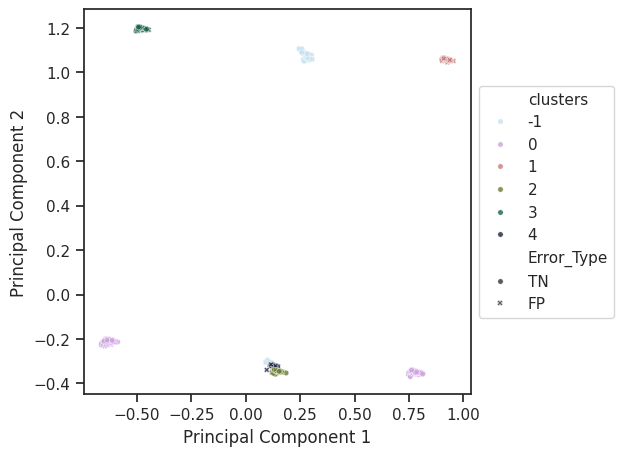

In [449]:
results_noDynEps_noErrorFeature = get_dbscan_clusters(data_now, bias_type=bias_type, verbose=False,
                                      eps=eps, dyn_eps=False,
                                      use_error_feature = False,
                                      min_acceptable_cluster_size=min_acceptable_cluster_size,
                                      min_error_diff=min_error_diff,
                                      max_iter=max_iter)

-2 ?? 0
-2 ?? 2
-2 ?? 6
Iteration  100 :  All iterations are done
Overall error rate:  0.33145780051150897
Cluster:  -1 	Size:  207 	Error rate:  0.32367149758454106
Cluster:  0 	Size:  518 	Error rate:  0.0
Cluster:  1 	Size:  123 	Error rate:  0.17886178861788618
Cluster:  2 	Size:  99 	Error rate:  0.0
Cluster:  3 	Size:  185 	Error rate:  0.24864864864864866
Cluster:  4 	Size:  66 	Error rate:  0.18181818181818182
Cluster:  5 	Size:  171 	Error rate:  1.0
Cluster:  6 	Size:  185 	Error rate:  0.0
Cluster:  7 	Size:  271 	Error rate:  1.0
Cluster:  8 	Size:  59 	Error rate:  1.0
Cluster:  9 	Size:  71 	Error rate:  0.0


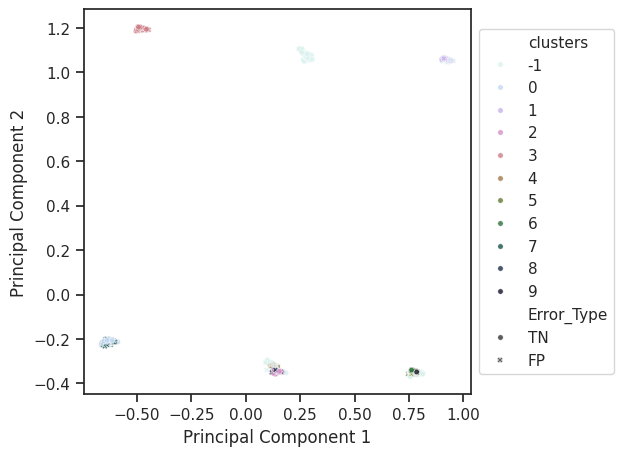

In [450]:
results_dynEps_errorFeature = get_dbscan_clusters(data_now, bias_type=bias_type, verbose=False,
                                      eps=eps, dyn_eps=True, eps_dyn_rate=eps_dyn_rate,
                                      min_acceptable_cluster_size=min_acceptable_cluster_size,
                                      min_error_diff=min_error_diff,
                                      max_iter=max_iter)

-2 ?? 0
-2 ?? 5
Iteration  100 :  All iterations are done
Overall error rate:  0.33145780051150897
Cluster:  -1 	Size:  323 	Error rate:  0.30959752321981426
Cluster:  0 	Size:  789 	Error rate:  0.34347275031685676
Cluster:  1 	Size:  146 	Error rate:  0.3082191780821918
Cluster:  2 	Size:  159 	Error rate:  0.3710691823899371
Cluster:  3 	Size:  185 	Error rate:  0.24864864864864866
Cluster:  4 	Size:  94 	Error rate:  0.425531914893617
Cluster:  5 	Size:  23 	Error rate:  0.30434782608695654
Cluster:  6 	Size:  236 	Error rate:  0.3389830508474576


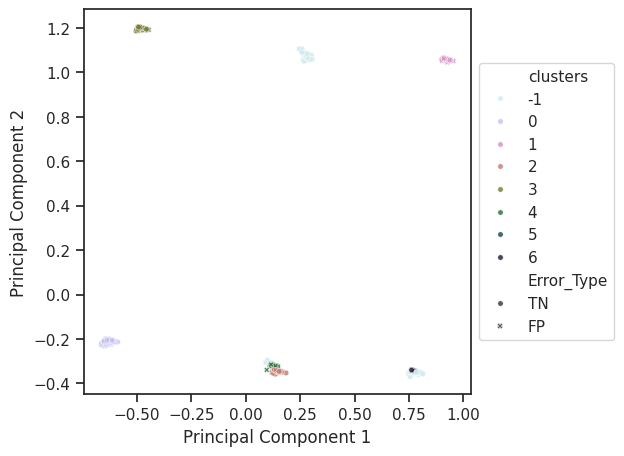

In [451]:
results_dynEps_noErrorFeature = get_dbscan_clusters(data_now, bias_type=bias_type, verbose=False,
                                      eps=eps, dyn_eps=True, eps_dyn_rate=eps_dyn_rate,
                                      use_error_feature = False,
                                      min_acceptable_cluster_size=min_acceptable_cluster_size,
                                      min_error_diff=min_error_diff,
                                      max_iter=max_iter)

# CLUSTERING RESULTS

In [435]:
VIZ_LABELS = ['StaticEpsilon_NoError', 'StaticEpsilon_WithError', 'DynamicEpsilon_NoError', 'DynamicEpsilon_WithError']
data_results = merge_results(results_noDynEps_noErrorFeature, results_noDynEps_errorFeature, results_dynEps_noErrorFeature, results_dynEps_errorFeature,
                             VIZ_LABELS)

## Distribution Matrix

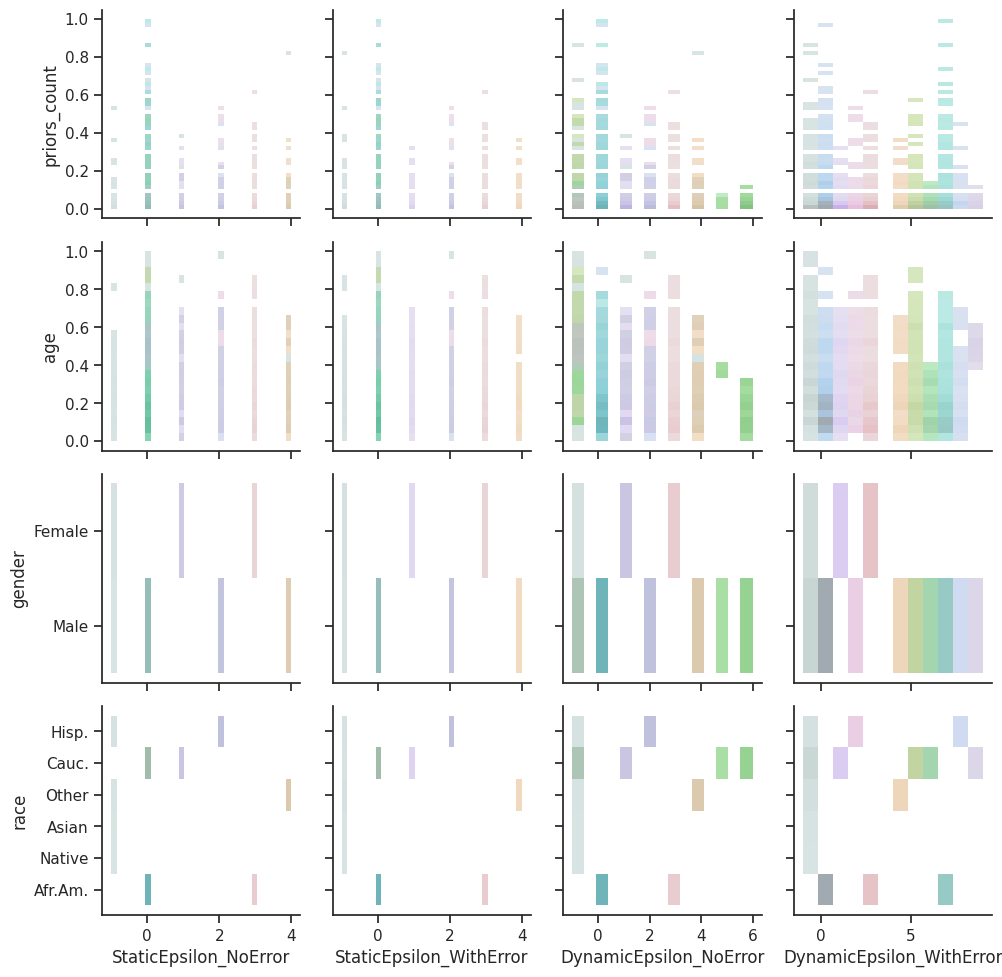

In [436]:
get_viz_matrix_all_results(data_results, VIZ_LABELS)

## Error Rates

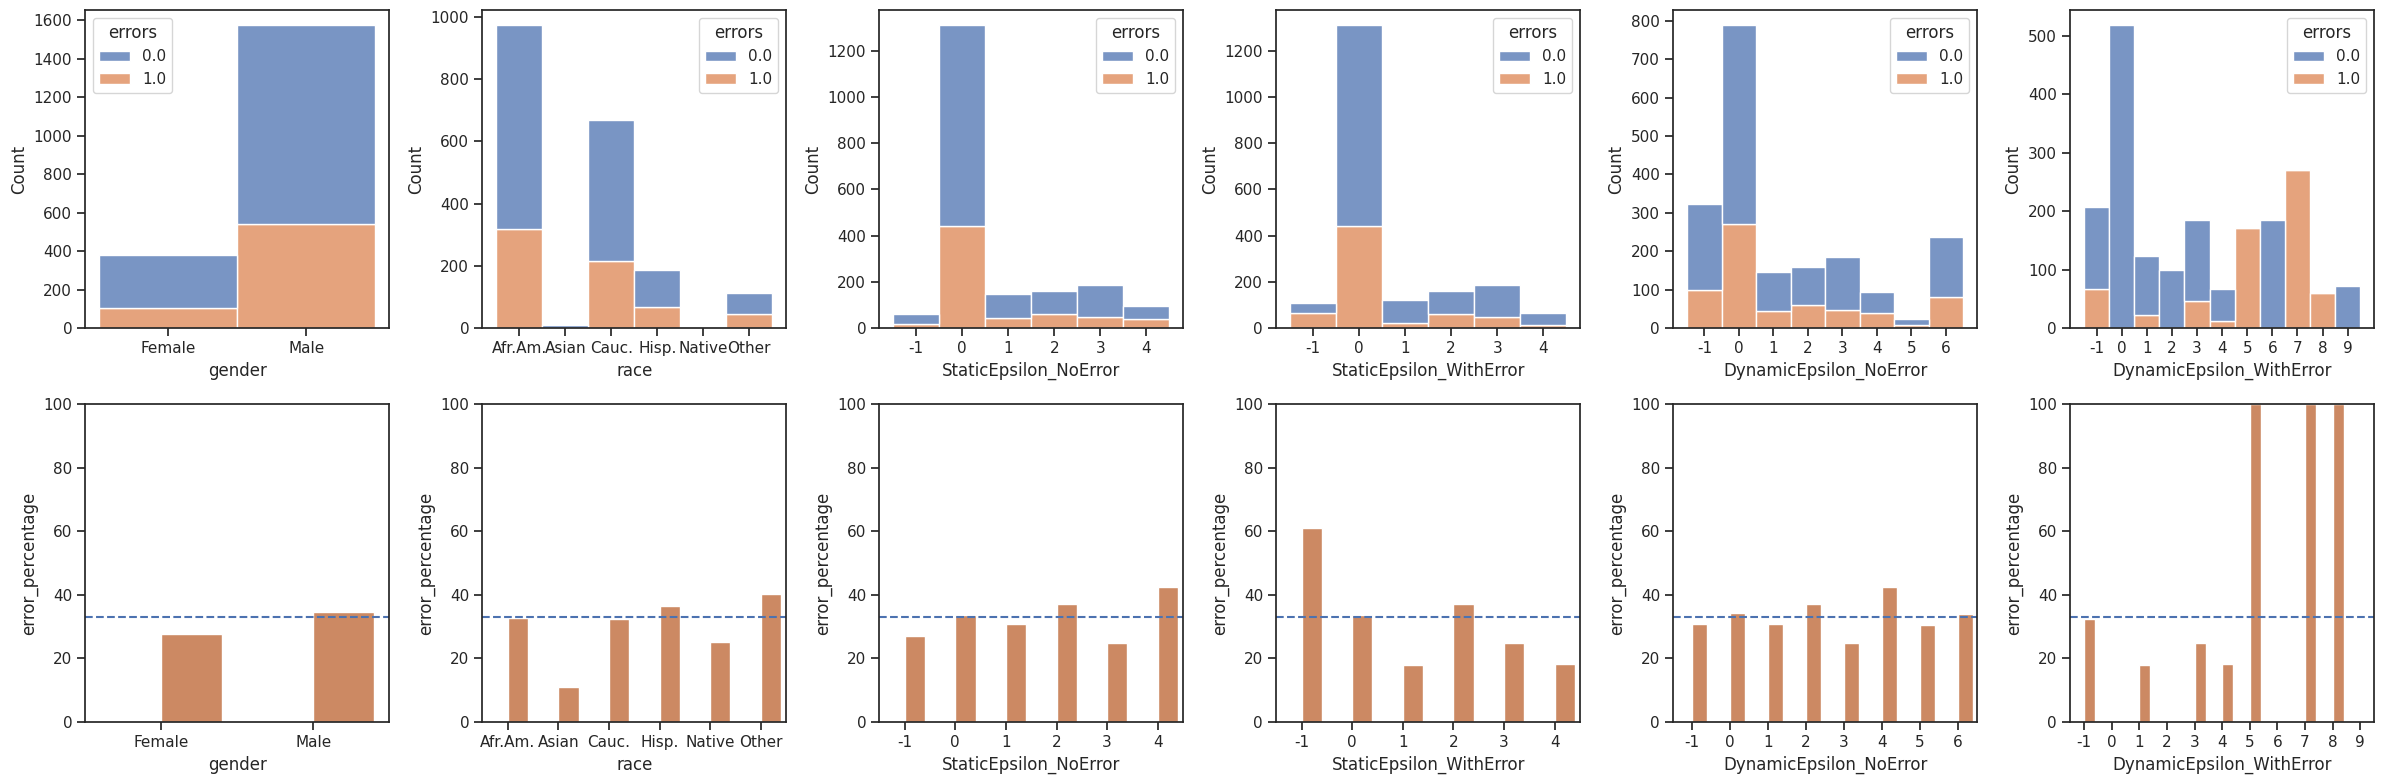

In [464]:
get_viz_error_dist_all_results(data_results, VIZ_LABELS)

## Consistency Matrix

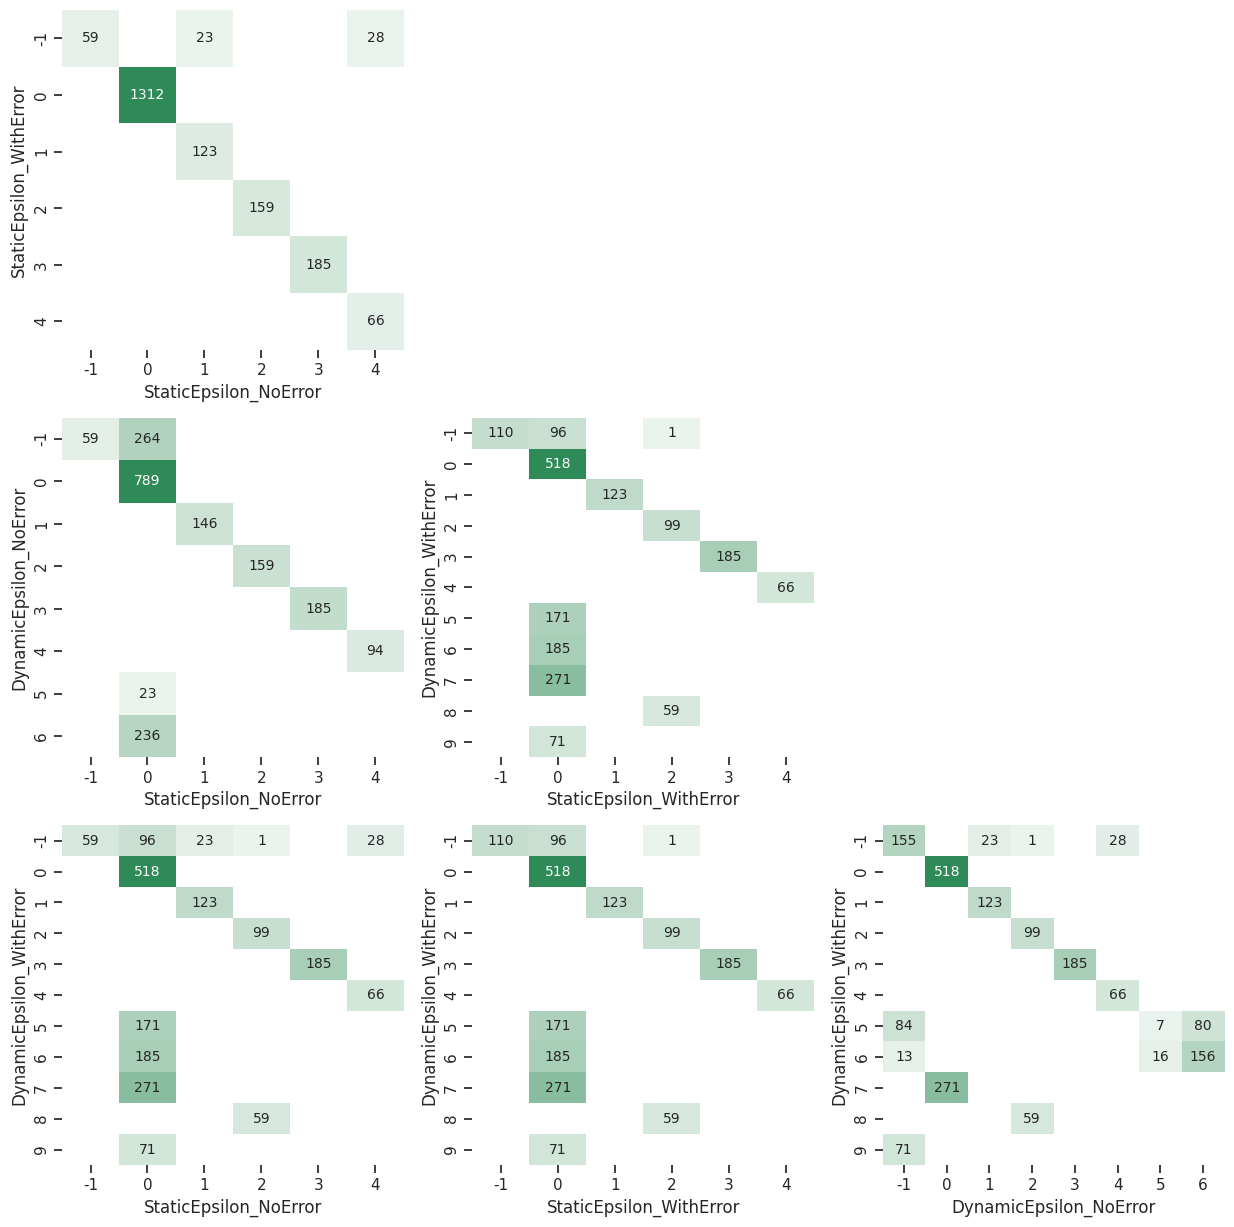

In [438]:
get_viz_overlap_all_results(data_results, VIZ_LABELS)